In [ ]:
!pip install tensorflow-addons==0.23.0
!pip install tf2crf keras_crf
!pip install gdown==4.5.4 --no-cache-dir

In [ ]:
import pandas as pd
import spacy
import spacy.displacy as displacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import nltk
import ast
from collections import Counter
from collections import defaultdict
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split
from tf2crf import CRF, ModelWithCRFLoss
from keras_crf import CRFModel

In [ ]:
data = pd.read_csv('NER-Data.csv')

In [ ]:
!gdown "https://drive.google.com/uc?id=1BpfbHu4denceXiv8yfdY3EHgjKIcULku"
embedding_file = './GoogleNews-vectors-negative300.bin.gz'

EDA

In [ ]:
data.shape

(47959, 4)

In [ ]:
data.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [ ]:
data.describe().transpose()

,count,unique,top,freq
Sentence #,47959,47959,Sentence: 1,1
Sentence,47959,47575,VOA 's Mil Arcega reports .,17
POS,47959,47214,"['NNP', 'POS', 'NNP', 'NNP', 'VBZ', '.']",39
Tag,47959,33318,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",450


In [ ]:
data.iloc[0]['Tag']

"['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']"

In [ ]:
nlp = spacy.load('en_core_web_sm')

for i in range(5):
  displacy.render(nlp(data['Sentence'].iloc[i]), style="ent",
                                                  jupyter=True)
  print("\n\n")

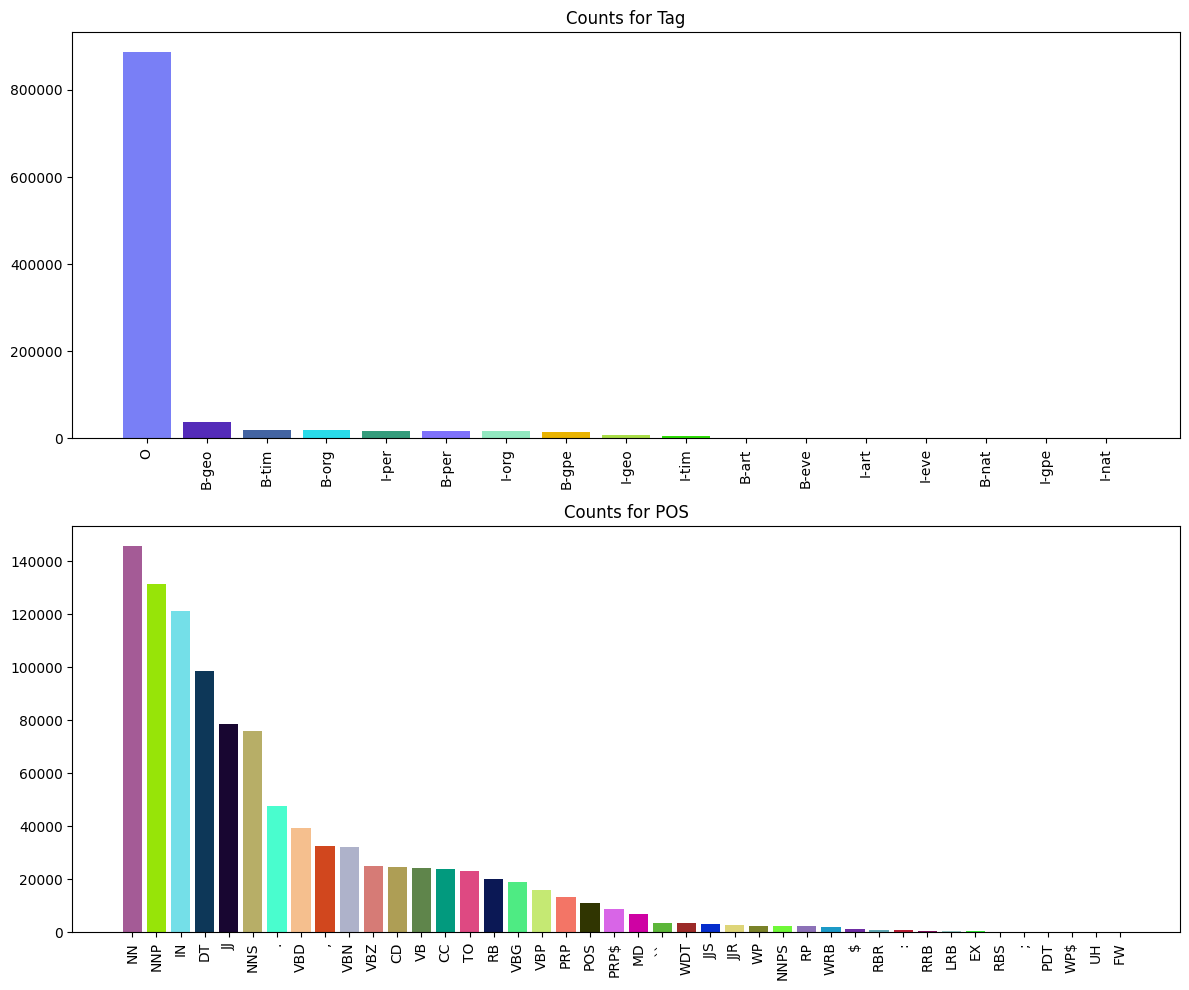

In [ ]:
plt.figure(figsize=(12, 10))

def plotCounts(col, i):
  counter = Counter()
  data[col].apply(lambda x : counter.update(ast.literal_eval(x)))

  arr = sorted(zip(list(counter.values()), list(counter.keys())), reverse=True)
  y, x = zip(*arr)

  plt.subplot(2, 1, i)
  plt.bar(x=x, height=y, color=np.random.rand(len(arr), 3))
  plt.xticks(rotation=90, ha='center')
  plt.title("Counts for " + col)
  plt.tight_layout()



plotCounts('Tag', 1)
plotCounts('POS', 2)

In [ ]:
"Number of duplicates: " + str(sum(data['Sentence'].duplicated()))

'Number of duplicates: 384'

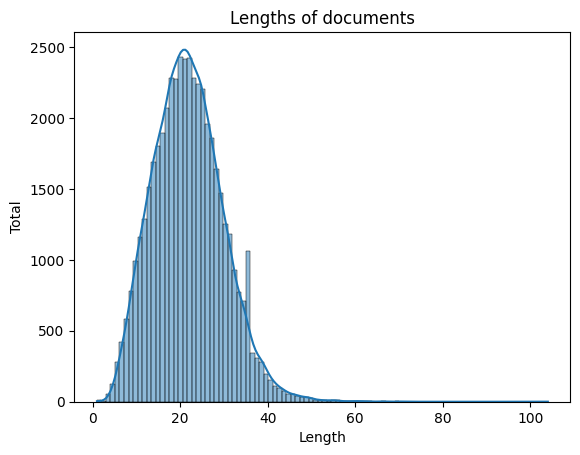

In [ ]:
arr = data['Sentence'].apply(lambda x: len(x.split())).values
sns.histplot(arr, bins=100, kde=True)
plt.title("Lengths of documents")
plt.xlabel("Length")
plt.ylabel("Total")
plt.show()

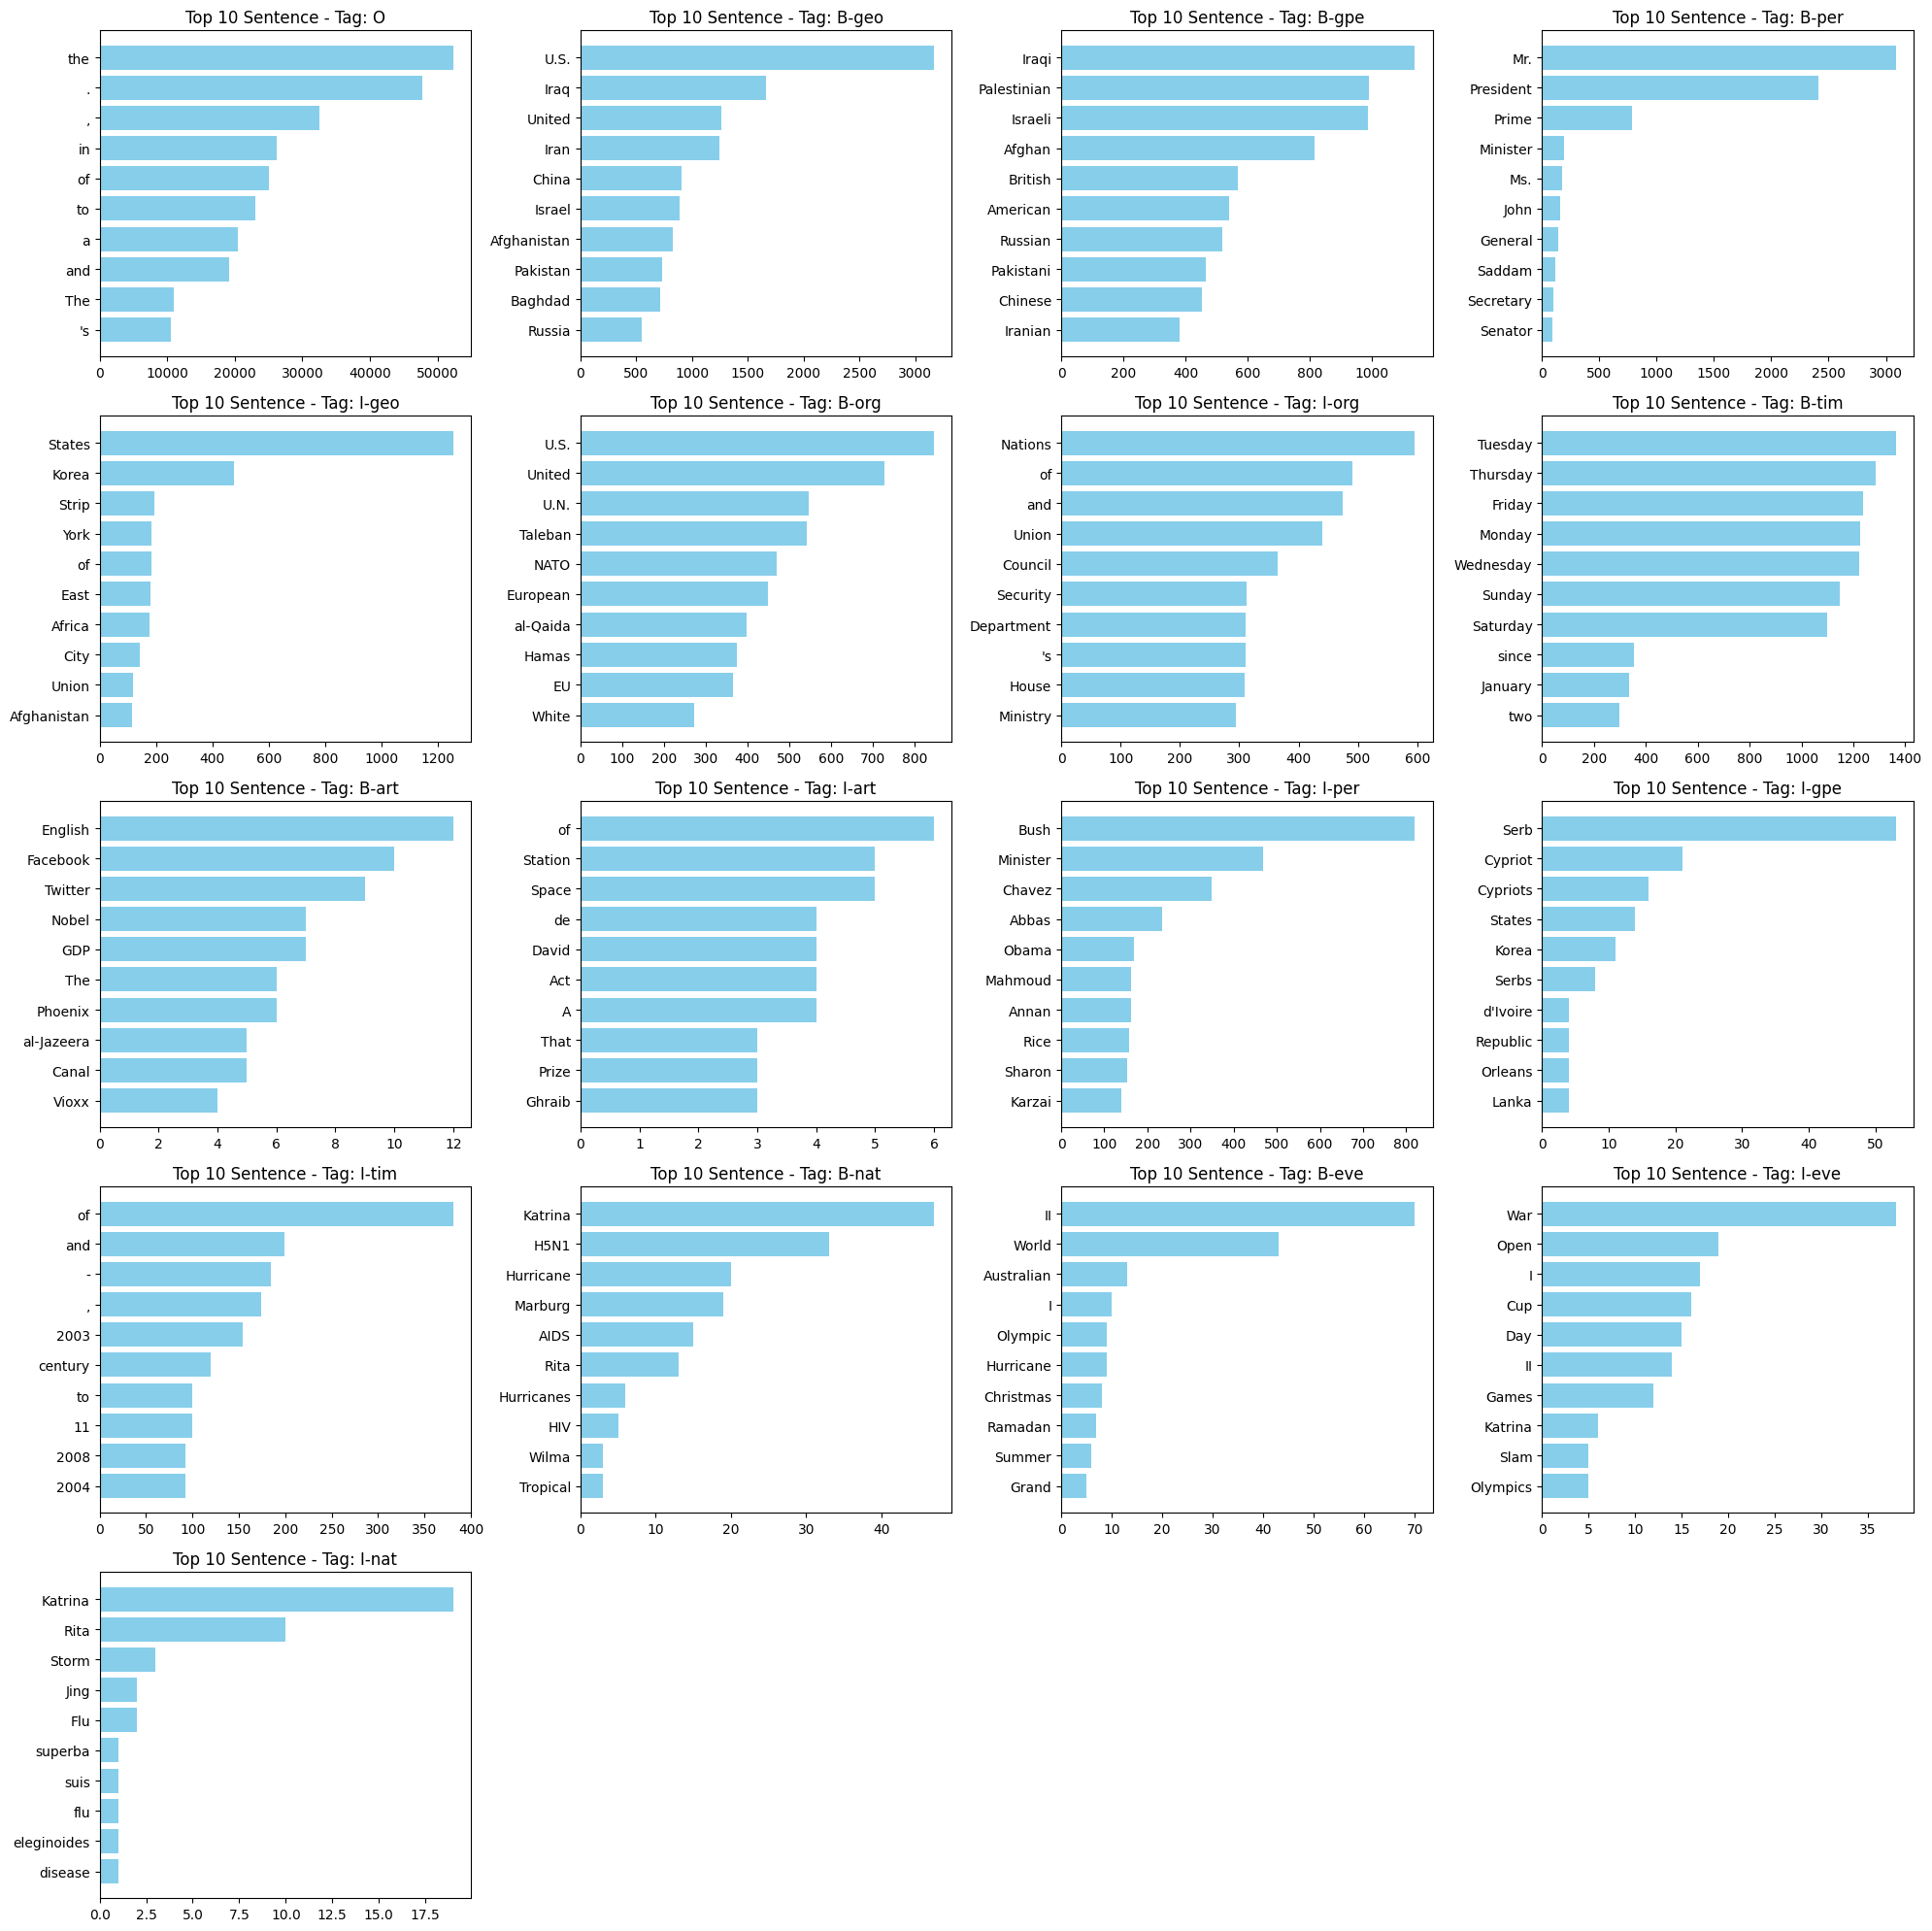

In [ ]:
def topThings(col, compareCol, color):
  counter = defaultdict(defaultdict)
  for i in range(len(data)):
    a = list(zip(data.iloc[i][compareCol].split(),
                ast.literal_eval(data.iloc[i][col])))
    for j in a:
      counter[j[1]][j[0]] = 1 if j[0] not in counter[j[1]] else \
                                          counter[j[1]][j[0]] + 1

  a = [sorted([(counter[i][j], i, j) for j in counter[i]],
                            reverse=True) for i in counter]

  plt.figure(figsize=(20, 20))
  c = 1
  for i in a:
    plt.subplot(5, 4, c)
    plt.barh(list(zip(*i))[2][:10][::-1], list(zip(*i))[0][:10][::-1],
                                                          color=color)
    plt.tight_layout()
    plt.title("Top 10 " + compareCol + " - " + col + ": " + i[0][1])
    c += 1

topThings('Tag', 'Sentence', 'skyblue')

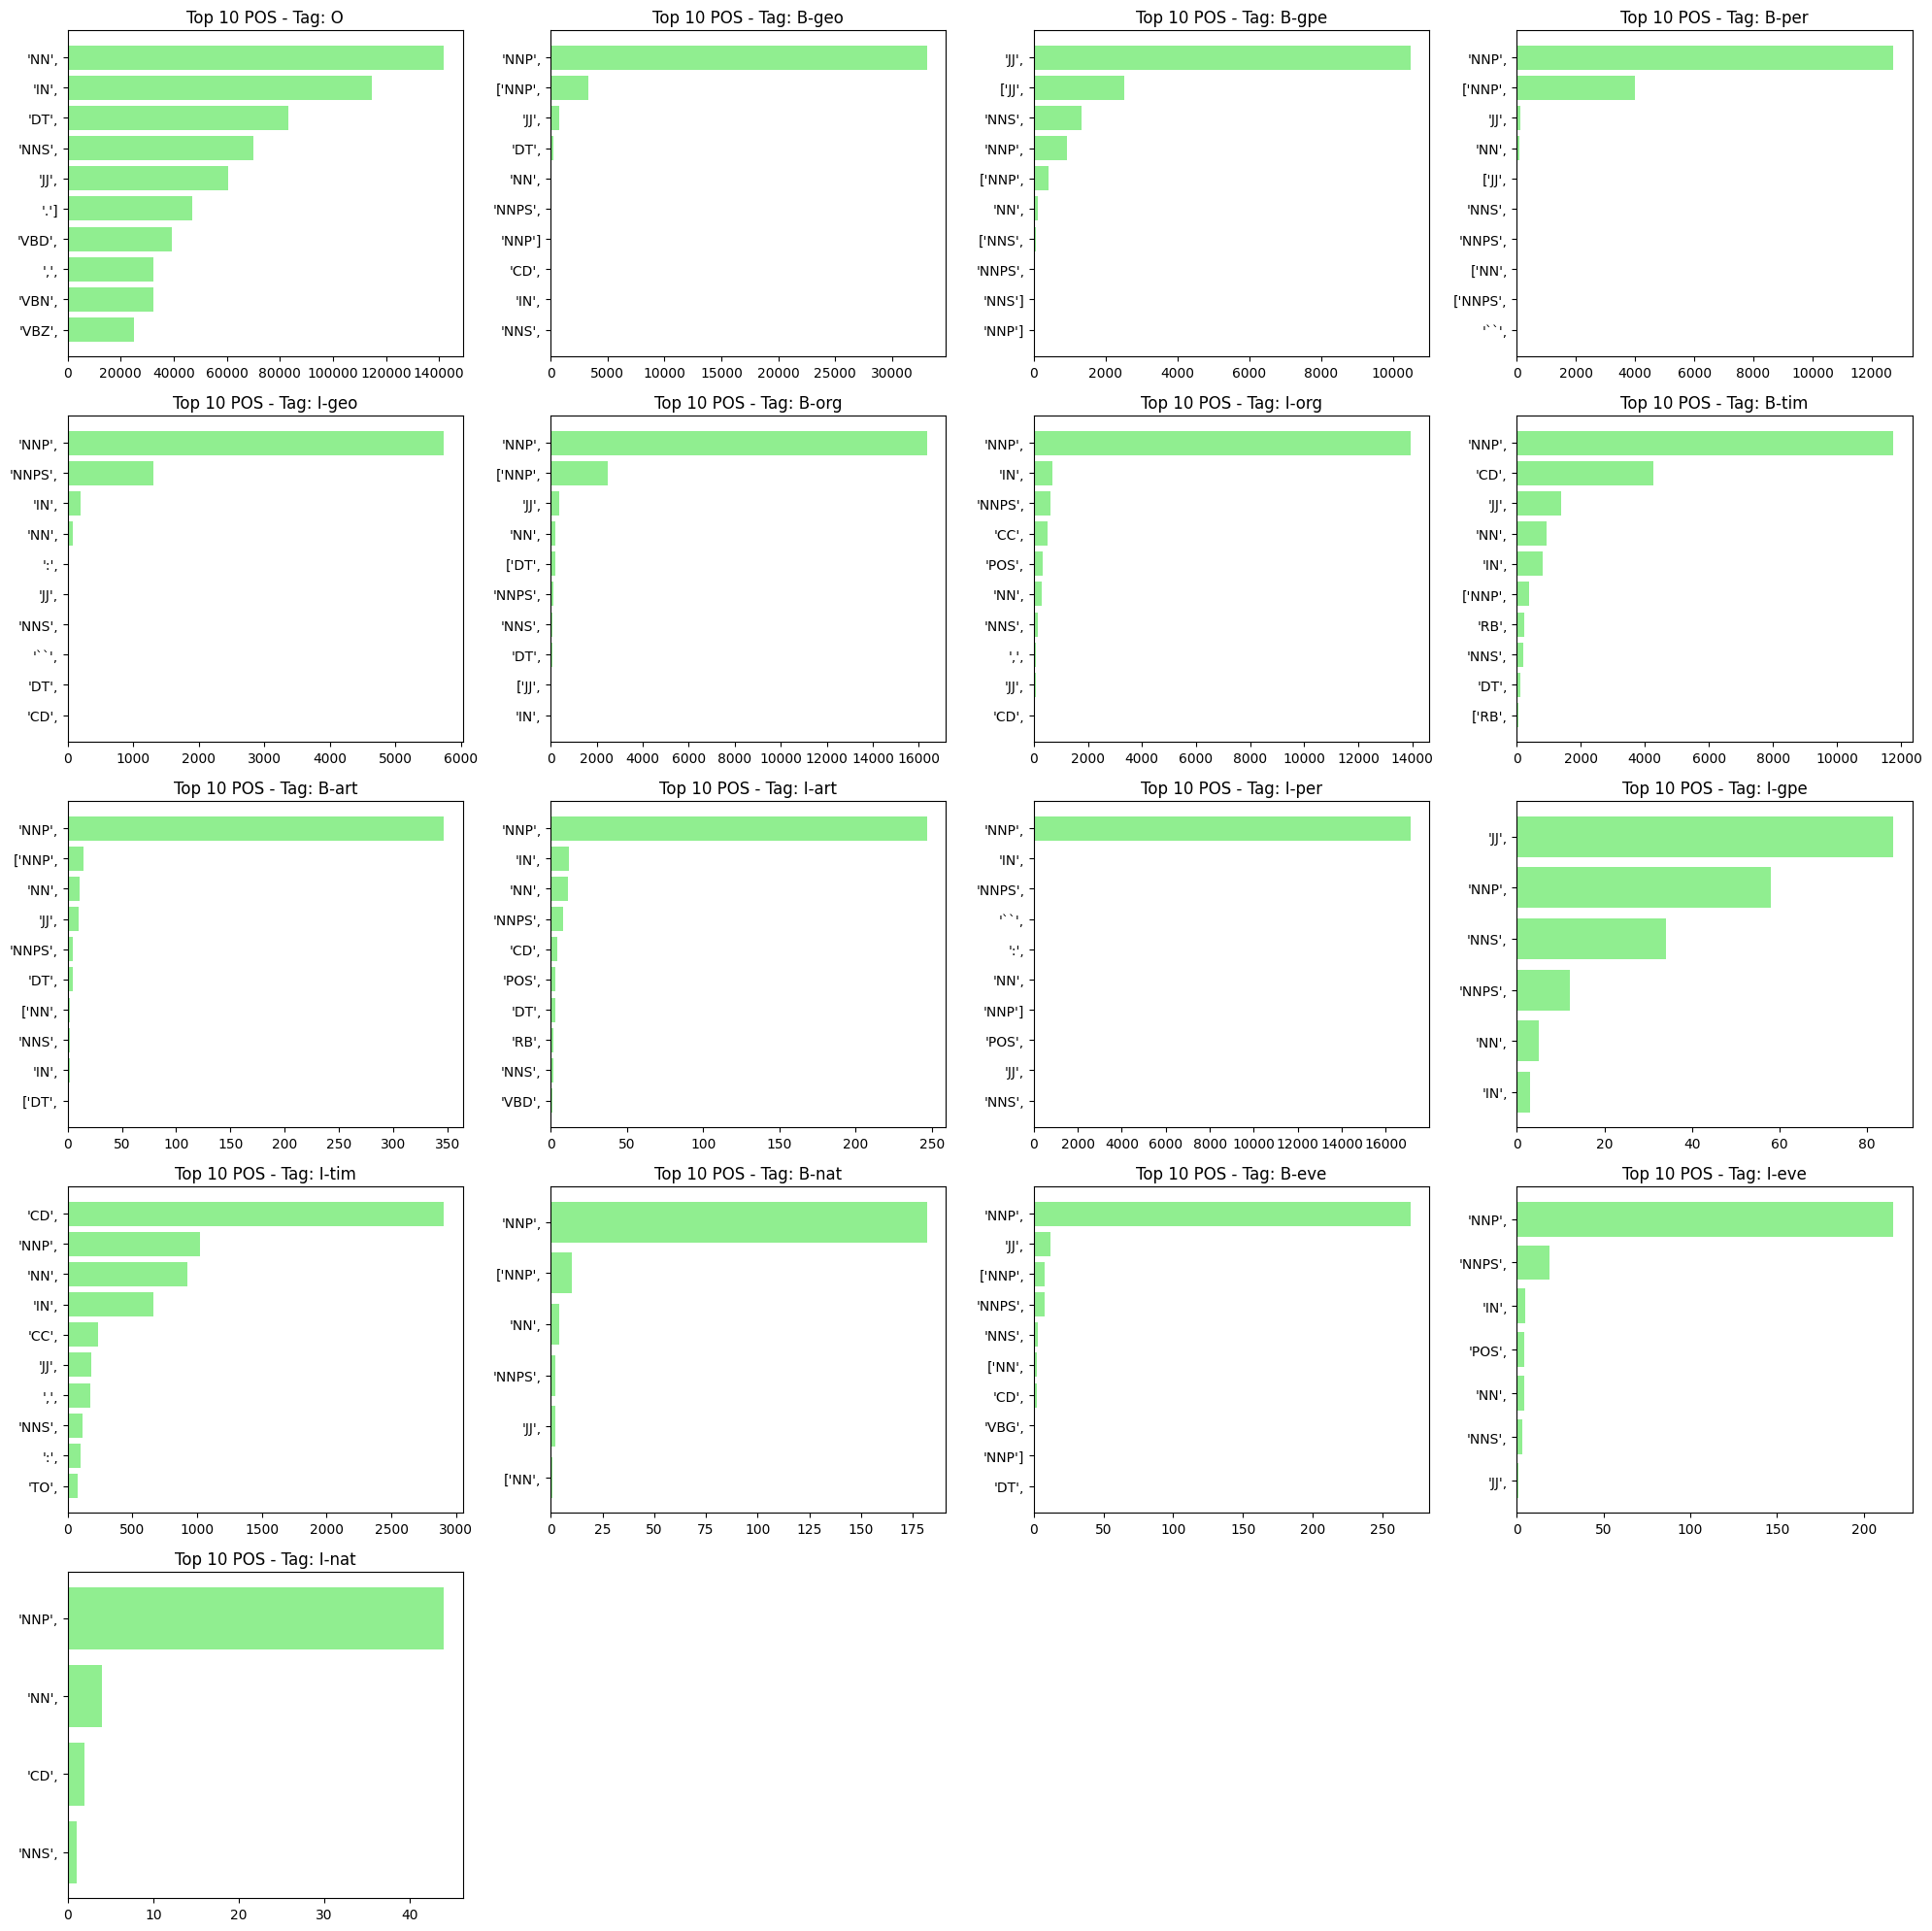

In [ ]:
topThings('Tag', 'POS', 'lightgreen')

Preprocessing


In [ ]:
data.drop_duplicates(subset=['Sentence'])
data['Sentence'] = data['Sentence'].apply(lambda x : x.split())
data.head(10)

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,"[Families, of, soldiers, killed, in, the, conf...","['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,"[They, marched, from, the, Houses, of, Parliam...","['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"[Police, put, the, number, of, marchers, at, 1...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,"[The, protest, comes, on, the, eve, of, the, a...","['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
5,Sentence: 6,"[The, party, is, divided, over, Britain, 's, p...","['DT', 'NN', 'VBZ', 'VBN', 'IN', 'NNP', 'POS',...","['O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', '..."
6,Sentence: 7,"[The, London, march, came, ahead, of, anti-war...","['DT', 'NNP', 'NN', 'VBD', 'RB', 'IN', 'JJ', '...","['O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', '..."
7,Sentence: 8,"[The, International, Atomic, Energy, Agency, i...","['DT', 'NNP', 'NNP', 'NNP', 'NNP', 'VBZ', 'TO'...","['O', 'B-org', 'I-org', 'I-org', 'I-org', 'O',..."
8,Sentence: 9,"[Iran, this, week, restarted, parts, of, the, ...","['NNP', 'DT', 'NN', 'VBD', 'NNS', 'IN', 'DT', ...","['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '..."
9,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","['JJ', 'NNS', 'VBP', 'PRP', 'VBP', 'TO', 'VB',...","['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '..."


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['Sentence'],
                                                    data['Tag'],
                                                    train_size=0.8,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    train_size=0.8,
                                                    random_state=42)

In [ ]:
len(X_train[29649]), len(ast.literal_eval(y_train[29649]))

(25, 25)

In [ ]:
y_train = y_train.apply(lambda x : ast.literal_eval(x))
y_val = y_val.apply(lambda x : ast.literal_eval(x))
y_test = y_test.apply(lambda x : ast.literal_eval(x))

In [ ]:
sentence_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
sentence_tokenizer.fit_on_texts(X_train)
len(sentence_tokenizer.word_index)

26415

In [ ]:
tag_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tag_tokenizer.fit_on_texts(y_train)
len(tag_tokenizer.word_index)

18

In [ ]:
X_train = sentence_tokenizer.texts_to_sequences(X_train)
X_val = sentence_tokenizer.texts_to_sequences(X_val)
X_test = sentence_tokenizer.texts_to_sequences(X_test)

y_train = tag_tokenizer.texts_to_sequences(y_train)
y_val = tag_tokenizer.texts_to_sequences(y_val)
y_test = tag_tokenizer.texts_to_sequences(y_test)

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format(embedding_file,
                                                    binary=True,
                                                    limit=200000)

embedding_matrix = np.zeros(shape=(len(sentence_tokenizer.word_index),
                                         word_vectors['hi'].shape[0]))

for i, word in enumerate(sentence_tokenizer.word_index):
  if word_vectors.has_index_for(word):
    embedding_matrix[i] = word_vectors[word].copy()

In [ ]:
maxlen = 400

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        padding='post',
                                                        maxlen=maxlen)

X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val,
                                                      padding='post',
                                                      maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       padding='post',
                                                       maxlen=maxlen)

y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train,
                                                        padding='post',
                                                        maxlen=maxlen)

y_val = tf.keras.preprocessing.sequence.pad_sequences(y_val,
                                                      padding='post',
                                                      maxlen=maxlen)

y_test = tf.keras.preprocessing.sequence.pad_sequences(y_test,
                                                       padding='post',
                                                       maxlen=maxlen)

In [ ]:
X_train.shape, y_train.shape

((30693, 400), (30693, 400))

### Create and Train Models

</br></br>

**Bidirectional LSTM Model**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=True,
        input_length=maxlen,
        mask_zero=True #following layers ignore padding
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128,
        return_sequences=True, #generates output at each time step
        kernel_initializer=tf.keras.initializers.random_normal(seed=42))
    ),
    tf.keras.layers.Dense(
        len(tag_tokenizer.word_index) + 1,
        activation='softmax',
        kernel_initializer=tf.keras.initializers.random_normal(seed=42)
    ),
    CRFModel(len(tag_tokenizer.word_index) + 1, 200, sparse_target=True)
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                                                  metrics=['accuracy'])

**Bidirectional LSTM - CRF Model**

In [ ]:
inputs = tf.keras.layers.Input(shape=(None,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(
    embedding_matrix.shape[0],
    embedding_matrix.shape[1],
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=True, input_length=maxlen, mask_zero=True)(inputs)

bilstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
    128, return_sequences=True,
    kernel_initializer=tf.keras.initializers.random_normal(seed=42))
  )(embedding_layer)

output = CRF(units=len(tag_tokenizer.word_index) + 1,
                        dtype='float32')(bilstm_layer)

BiLSTM_CRF = tf.keras.Model(inputs, output)
model = ModelWithCRFLoss(BiLSTM_CRF, sparse_target=True)
model.compile(optimizer='adam', metrics=['acc'])


tf.config.run_functions_eagerly(True)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=3)

history = model.fit(X_train, y_train, epochs=10,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    callbacks=[es_callback])

**Bidirectional GRU - CRF Model**

In [ ]:
inputs = tf.keras.layers.Input(shape=(None,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(
    embedding_matrix.shape[0],
    embedding_matrix.shape[1],
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=True, input_length=maxlen, mask_zero=True)(inputs)

biGRU_layer = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(
          128, return_sequences=True, #generates output at each time step
          kernel_initializer=tf.keras.initializers.random_normal(seed=42)
        ))(embedding_layer)

output = CRF(units=len(tag_tokenizer.word_index) + 1,
                        dtype='float32')(biGRU_layer)

BiGRU_CRF = ModelWithCRFLoss(tf.keras.Model(inputs, output),
                                          sparse_target=True)
BiGRU_CRF.compile(optimizer='adam')

**Gated Convolutional Network Model**

In [ ]:
class GatedLinearUnit(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GatedLinearUnit, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
      A = inputs[0]
      B = tf.math.sigmoid(inputs[1])
      return tf.multiply(A, B)

inputs = tf.keras.layers.Input(shape=(None,), dtype='int32')
e = tf.keras.layers.Embedding(
          embedding_matrix.shape[0],
          embedding_matrix.shape[1],
          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
          trainable=True,
          input_length=maxlen,
          mask_zero=True)(inputs)
conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=3)(e)
conv2 = tf.keras.layers.Conv1D(filters=32, kernel_size=3)(e)
glu   = GatedLinearUnit()([conv1, conv2])
max_pool = tf.keras.layers.GlobalMaxPooling1D()(glu)
output = tf.keras.layers.Dense(16, activation='softmax')(max_pool)

GCNN = tf.keras.Model(inputs, output)
GCNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

tf.config.run_functions_eagerly(True)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=3)
history = GCNN.fit(X_train, y_train, epochs=10,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    callbacks=[es_callback])

**Gated Relational Network Model**

In [ ]:
class RelationLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(RelationLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="b", shape=(self.units,), initializer="random_normal", trainable=True,
        )

    def call(self, inputs):
        print("This is input: ", inputs)
        print("end ------------------------------ \n\n")
        return tf.matmul(inputs, self.w) + self.b



inputs = tf.keras.layers.Input(shape=(None,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(
          embedding_matrix.shape[0],
          embedding_matrix.shape[1],
          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
          trainable=True,
          input_length=maxlen,
          mask_zero=True)(inputs)
Representation_layer = tf.keras.layers.Convolution1D(8, 3)(embedding_layer)
Representation_layer = tf.keras.layers.MaxPooling1D(2)(Representation_layer)
Context_layer_conv_1 = tf.keras.layers.Convolution1D(8, 1)(Representation_layer)
Context_layer_conv_2 = tf.keras.layers.Convolution1D(8, 3)(Context_layer_conv_1)
Context_layer_conv_3 = tf.keras.layers.Convolution1D(8, 5)(Context_layer_conv_2)
Context_layer_act    = tf.keras.layers.Activation('tanh')(Context_layer_conv_3)
Context_layer_pool   = tf.keras.layers.MaxPooling1D(2)(Context_layer_act)
relation_layer = RelationLayer(1)(Context_layer_pool)
output = CRF(units=len(tag_tokenizer.word_index) + 1, dtype='float32')(relation_layer)
gated_relation_network = ModelWithCRFLoss(tf.keras.Model(inputs, output),
                                                      sparse_target=True)
gated_relation_network.compile(optimizer='adam', metrics=['acc'])
gated_relation_network.predict(X_train[:10])

In [ ]:
tf.config.run_functions_eagerly(True)



es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=3)

history = model.fit(X_train, y_train, epochs=20,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    callbacks=[es_callback])

In [ ]:
model.evaluate(X_test, y_test)

300/300 [==============================] - 12s 39ms/step - loss: 0.1706 - accuracy: 0.9554


[0.1705845147371292, 0.9553756713867188]

In [ ]:
s = "Hello - Thank you for your interest in the 286165 Software Engineering Intern – Summer 2024 position at CACI. This requisition has been filled and therefore your application is no longer under consideration for this position. We sincerely appreciate your interest and encourage you to continue to review and apply for other opportunities at CACI by visiting our career site at https://careers.caci.com. Thank you again for your interest in CACI. We wish you the best of luck on your search. Best Regards, CACI Talent Acquisition Team"
s = s.split()
s_len = len(s)
s = sentence_tokenizer.texts_to_sequences([s])
s = tf.keras.preprocessing.sequence.pad_sequences(s, padding='post',
                                                  maxlen=maxlen)[0]

pred = tag_tokenizer.sequences_to_texts([np.argmax(model.predict(np.expand_dims(s, axis=0))[0], axis=1)])[0].split()

1/1 [==============================] - 0s 49ms/step


In [ ]:
s = "Hello - Thank you for your interest in the 286165 Software Engineering Intern – Summer 2024 position at CACI. This requisition has been filled and therefore your application is no longer under consideration for this position. We sincerely appreciate your interest and encourage you to continue to review and apply for other opportunities at CACI by visiting our career site at https://careers.caci.com. Thank you again for your interest in CACI. We wish you the best of luck on your search. Best Regards, CACI Talent Acquisition Team"
s = s.split()

for i in range(len(pred)):
  if pred[i] != 'o':
    if i < len(s):
      print(s[i], i, pred[i])

Summer 15 b-org
2024 16 i-org
